# Wavelength & shrinkage compensation test
## 23.01.05.
## MHChoi

301


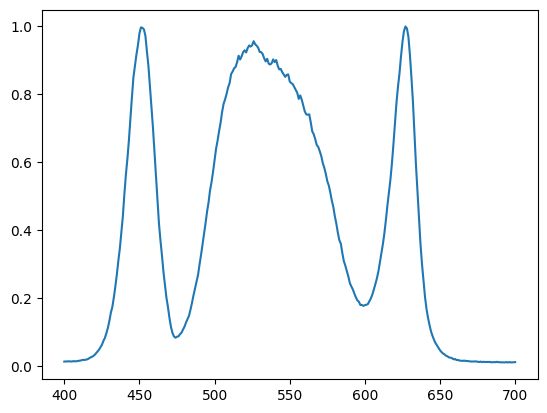

In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


wvl_white = pd.read_csv('qumi_white.csv')
wvl_white.columns = ['Wavelength', 'Intensity']
wvl_white['Wavelength'] = np.int16(np.round(wvl_white['Wavelength'].values))


wvl_white = wvl_white.groupby(['Wavelength']).mean()

wvl_white = wvl_white.loc[400:700]
wvl_white['Intensity'] = wvl_white['Intensity'] / np.max(np.max(wvl_white['Intensity']))
plt.figure()
plt.plot(wvl_white.index, wvl_white['Intensity'])

print(len(wvl_white))

### HOE class 만들기

In [16]:
class HOE:
    def __init__(self, mju = 1, sigma0 = 0, sigma1 = 0, mean_n = 1.504, del_n = 0.034, thickness = 16.8e-6, axial_shrinkage = 0):
            self.mju = mju
            self.sigma0 = sigma0
            self.sigma1 = sigma1
            self.mean_n = mean_n
            self.del_n = del_n
            self.thickness = thickness
            self.axial_shrinkage = axial_shrinkage

In [17]:
import numpy as np
import matplotlib.pyplot as plt
import sympy as sym

# Parameters
cm, mm, um, nm = (1e-2, 1e-3, 1e-6, 1e-9)
wavelength_record = np.array([488*nm, 532*nm, 660*nm])
wavelength_display_center = np.array([453*nm, 532*nm, 628*nm])

alpha = np.deg2rad(10); beta = np.deg2rad(60) # angle in waveguide
k_r = 2*np.pi / wavelength_record
k_d = 2*np.pi / wavelength_display_center

shrinkage_HOE = 0.6 / 100
n_wg = 1.5
solution_BGR = dict()
for i in range(3):
    k_vec_d_in_ref = k_d[i] * np.array([np.sin(alpha), np.cos(alpha)], dtype='float')
    k_vec_d_in_sig = k_d[i] * np.array([np.sin(beta), -np.cos(beta)], dtype='float')
    K_vec_d_in = k_vec_d_in_ref - k_vec_d_in_sig
    K_vec_d_in_shrk = K_vec_d_in
    K_vec_d_in_shrk[1] = (1+shrinkage_HOE) * K_vec_d_in_shrk[1]

    x = sym.symbols('x')
    z = sym.symbols('z')

    eq1 = x**2 + z**2 - k_r[i] **2
    eq2 = (x+K_vec_d_in_shrk[0])**2 + (z+K_vec_d_in_shrk[1])**2 - k_r[i]**2

    solutions = sym.solve([eq1, eq2], real=True)
    solution_BGR[i] = solutions[1]
 


When recording wavelength = 488.0 nm
And display wavelength = 453.0 nm
Alpha deviation in air at prism surface= 1.6445542256464873
Beta deviation in air at prism surface= 6.761907376481957
Incident angle inside prism = 55.497887532022446 

When recording wavelength = 532.0 nm
And display wavelength = 532.0 nm
Alpha deviation in air at prism surface= 6.4662859312004395
Beta deviation in air at prism surface= 0.8048665201072424
Incident angle inside prism = 59.46343212439943 

When recording wavelength = 660.0 nm
And display wavelength = 628.0 nm
Alpha deviation in air at prism surface= 3.3165287196800657
Beta deviation in air at prism surface= 4.659506544415501
Incident angle inside prism = 56.89556640586656 



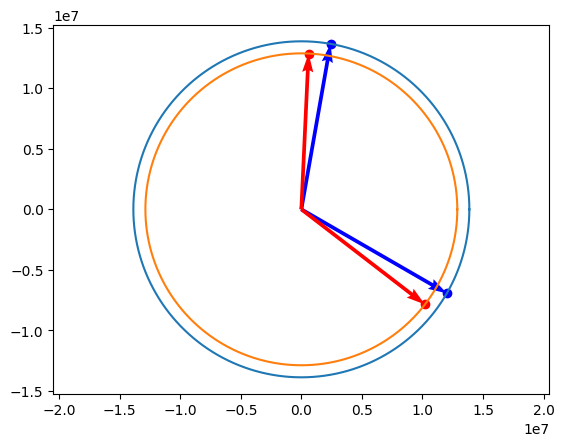

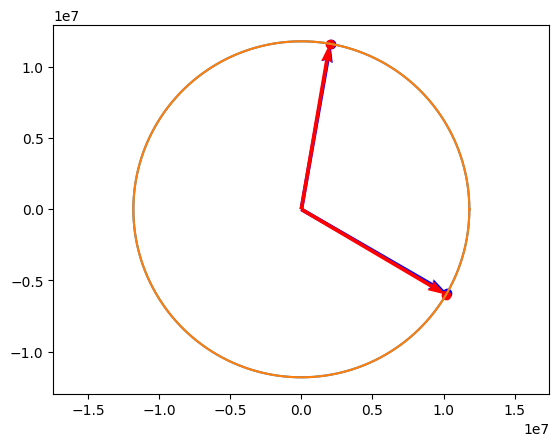

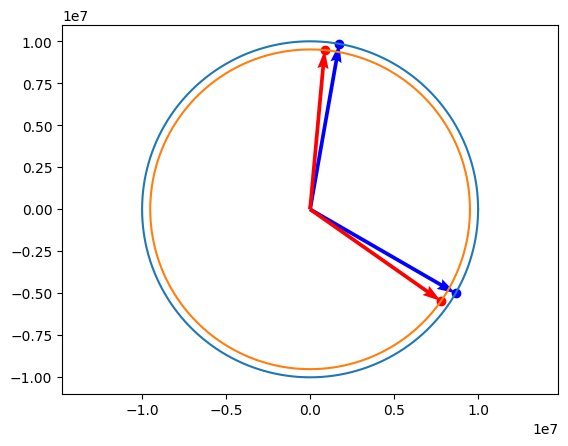

In [18]:
for i in range(3):

    k_vec_d_in_ref = k_d[i] * np.array([np.sin(alpha), np.cos(alpha)], dtype='float')
    k_vec_d_in_sig = k_d[i] * np.array([np.sin(beta), -np.cos(beta)], dtype='float')
    K_vec_d_in = k_vec_d_in_ref - k_vec_d_in_sig
    K_vec_d_in_shrk = K_vec_d_in
    K_vec_d_in_shrk[1] = (1+shrinkage_HOE) * K_vec_d_in_shrk[1]

    k_vec_r_in_ref = np.array([solution_BGR[i][x]+K_vec_d_in_shrk[0], solution_BGR[i][z]+K_vec_d_in_shrk[1]], dtype=float)
    k_vec_r_in_sig = np.array([solution_BGR[i][x], solution_BGR[i][z]], dtype=float)

    print('When recording wavelength =',wavelength_record[i]/nm, 'nm')
    print('And display wavelength =',wavelength_display_center[i]/nm, 'nm')
    alpha_mod_wg = np.arcsin(k_vec_r_in_ref[0]/k_d[i])
    alpha_mod_air = np.arcsin(1/n_wg * np.sin(alpha_mod_wg)) 
    print("Alpha deviation in air at prism surface=",np.rad2deg(alpha_mod_air))

    beta_mod_prism = np.arccos(np.abs(k_vec_r_in_sig[1])/k_d[i])
    beta_mod_air = np.arcsin(1*n_wg * np.sin(np.deg2rad(60)-beta_mod_prism)) # considered prism with 60 degree
    print("Beta deviation in air at prism surface=", np.rad2deg(beta_mod_air))
    print("Incident angle inside prism =", np.rad2deg(beta_mod_prism), '\n')


    x_domain = np.linspace(-k_d[i], k_d[i], 1001)
    y_domain = np.linspace(-k_d[i], k_d[i], 1001)
    angle_domain = np.deg2rad(np.linspace(0, 360, 721))
    xx,yy = np.meshgrid(x_domain, y_domain)

    plt.figure()

    plt.plot(k_d[i]*np.cos(angle_domain), k_d[i]*np.sin(angle_domain))
    plt.quiver(0,0,k_vec_d_in_ref[0],k_vec_d_in_ref[1], units='xy', scale=1, color='b')
    plt.quiver(0,0,k_vec_d_in_sig[0],k_vec_d_in_sig[1], units='xy', scale=1, color='b')
    plt.scatter(k_vec_d_in_ref[0],k_vec_d_in_ref[1], color='b')
    plt.scatter(k_vec_d_in_sig[0],k_vec_d_in_sig[1], color='b')


    plt.plot(k_r[i]*np.cos(angle_domain), k_r[i]*np.sin(angle_domain))
    plt.quiver(0,0,k_vec_r_in_ref[0],k_vec_r_in_ref[1], units='xy', scale=1, color='r')
    plt.quiver(0,0,k_vec_r_in_sig[0],k_vec_r_in_sig[1], units='xy', scale=1, color='r')
    plt.scatter(k_vec_r_in_ref[0],k_vec_r_in_ref[1], color='r')
    plt.scatter(k_vec_r_in_sig[0],k_vec_r_in_sig[1], color='r')


    plt.axis('equal')

    

위 코드들은 모두 PG에 의한 in-coupler의 incident angle 바꾸지 않은 값임.

추가로.. prism을 회전하는 것이 아니라 양쪽의 빛 각도를 조절하는 방법을 적용한 것.



아래 코드는 prism 회전 + single beam rotation을 고려한 코드.

쓰인 파라미터는 아래 사진과 같음

[12011916.3194319  20805249.36152181]
[12011916.3194319  20681162.38719862]
NEW_beta_wg= 51.90524391554463
phi_prism_air= 12.231465183979724
phi_mirror_air= 24.873398223163232
[12011916.3194319  20681162.38719862]
[12011916.3194319  20805249.36152181]
[10228191.90357642 17715748.04655898]
[10228191.90357642 17610087.5214304 ]
NEW_beta_wg= 60.58928545091839
phi_prism_air= -0.8837184341376908
phi_mirror_air= -1.3216211358507373
[10228191.90357642 17610087.5214304 ]
[10228191.90357642 17715748.04655899]
[ 8664646.64443098 15007608.21778564]
[ 8664646.64443098 14918099.62006525]
NEW_beta_wg= 55.17870465419188
phi_prism_air= 7.249266148268848
phi_mirror_air= 14.937837925047495
[ 8664646.64443098 14918099.62006525]
[ 8664646.64443098 15007608.21778564]


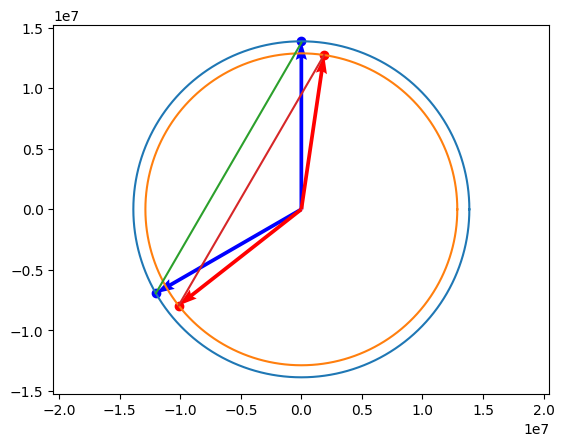

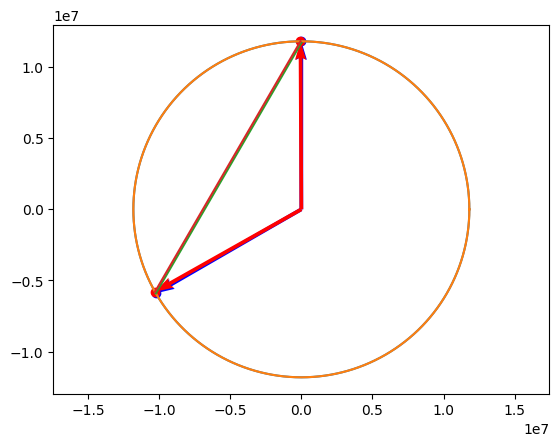

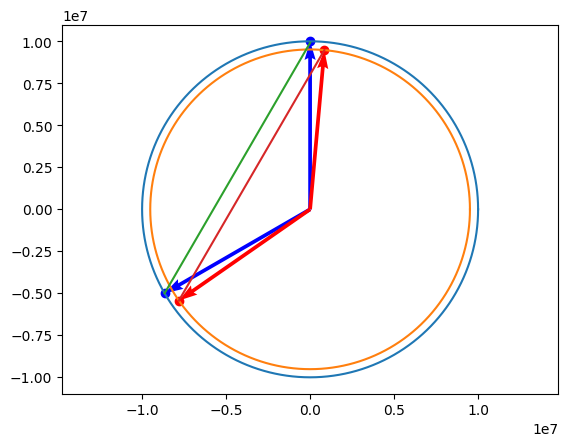

In [87]:
import numpy as np
import matplotlib.pyplot as plt
import sympy as sym

# Parameters
cm, mm, um, nm = (1e-2, 1e-3, 1e-6, 1e-9)
wvl_record = np.array([488*nm, 532*nm, 660*nm])
wvl_disp_center = np.array([453*nm, 532*nm, 628*nm])
num_wvl = len(wvl_record)
shrinkage_HOE = 0.6 / 100 # achieved from project with naver labs
n_air = 1.000277
n_wg = 1.5 # later, this should be modified with consider of color aberration and HOE refractive index
theta_prism = np.deg2rad(60) # our thick 60-30-90-90 prism
phi_prism = float()
phi_mirror = float()
solution_BGR = dict()

# For HOE input coupler
for i in range(3):

   # Sign of angle is (+) when it is clockwise, (-) when it is CCW
   
   # Ideal angles for display's central wavelength inside the waveguide or HOE (n=1.5)
   alpha_air = 0
   #alpha_air = -angle_PG_deflect(wvl_disp_center[i]) # diflected angle in air by the PG (reference alpha)
   alpha_wg = np.arcsin(n_air/n_wg * np.sin(alpha_air)) # refracted light angle in wvg
   beta_wg = theta_prism # TIR angle in waveguide
   
   k_ref = 2*np.pi / wvl_record[i]
   k_disp = 2*np.pi / wvl_disp_center[i]

   # For plotting
   x_domain = np.linspace(-k_disp, k_disp, 1001)
   y_domain = np.linspace(-k_disp, k_disp, 1001)
   angle_domain = np.deg2rad(np.linspace(0, 360, 721))
   xx, yy = np.meshgrid(x_domain, y_domain)

   # Draw k-vector circles
   plt.figure()
   plt.plot(k_disp*np.cos(angle_domain), k_disp*np.sin(angle_domain))
   plt.plot(k_ref*np.cos(angle_domain), k_ref*np.sin(angle_domain))

   k_vec_d_in_ref = k_disp * np.array([np.sin(alpha_wg), np.cos(alpha_wg)], dtype='float')
   k_vec_d_in_sig = k_disp * np.array([-np.sin(beta_wg), -np.cos(beta_wg)], dtype='float')
   K_vec_d_in = k_vec_d_in_ref - k_vec_d_in_sig
   print(K_vec_d_in)

   # grating vector which should be generated
   K_vec_d_in_precomp = K_vec_d_in
   K_vec_d_in_precomp[1] = 1/(1+shrinkage_HOE) * K_vec_d_in_precomp[1]
   print(K_vec_d_in_precomp)

   plt.quiver(0, 0, k_vec_d_in_ref[0], k_vec_d_in_ref[1], units='xy', scale=1, color='b')
   plt.quiver(0, 0, k_vec_d_in_sig[0], k_vec_d_in_sig[1], units='xy', scale=1, color='b')
   plt.plot([k_vec_d_in_sig[0], k_vec_d_in_sig[0] + K_vec_d_in[0]],[k_vec_d_in_sig[1], k_vec_d_in_sig[1] + K_vec_d_in[1]])
   plt.scatter(k_vec_d_in_ref[0], k_vec_d_in_ref[1], color='b')
   plt.scatter(k_vec_d_in_sig[0], k_vec_d_in_sig[1], color='b')

   x = sym.symbols('x')
   z = sym.symbols('z')
   eq1 = x**2 + z**2 - k_ref **2
   eq2 = (x+K_vec_d_in_precomp[0])**2 + (z+K_vec_d_in_precomp[1])**2 - k_ref**2

   solutions = sym.solve([eq1, eq2], real=True)
   solution_BGR[i] = solutions[0]

   k_vec_r_in_ref = np.array([solution_BGR[i][x]+K_vec_d_in_precomp[0], solution_BGR[i][z]+K_vec_d_in_precomp[1]], dtype=float)
   k_vec_r_in_sig = np.array([solution_BGR[i][x], solution_BGR[i][z]], dtype=float)
   K_vec_by_record = k_vec_r_in_ref - k_vec_r_in_sig
   K_vec_by_record[1] = (1+shrinkage_HOE)*K_vec_by_record[1]

   plt.quiver(0, 0, k_vec_r_in_ref[0], k_vec_r_in_ref[1], units='xy', scale=1, color='r')
   plt.quiver(0, 0, k_vec_r_in_sig[0], k_vec_r_in_sig[1], units='xy', scale=1, color='r')
   plt.plot([k_vec_r_in_sig[0], k_vec_r_in_sig[0] + K_vec_d_in_precomp[0]],[k_vec_r_in_sig[1], k_vec_r_in_sig[1] + K_vec_d_in_precomp[1]])
   plt.scatter(k_vec_r_in_ref[0], k_vec_r_in_ref[1], color='r')
   plt.scatter(k_vec_r_in_sig[0], k_vec_r_in_sig[1], color='r')


   NEW_beta_wg = np.arctan(k_vec_r_in_sig[0]/k_vec_r_in_sig[1])
   print('NEW_beta_wg=',np.rad2deg(NEW_beta_wg))
   phi_prism_wg = theta_prism - NEW_beta_wg
   phi_prism_air = np.arcsin(n_wg / n_air * phi_prism_wg)

   NEW_alpha_wg = np.arctan(k_vec_r_in_ref[0]/k_vec_r_in_ref[1])
   phi_mirror_air = np.arcsin(n_wg/n_air*np.sin(NEW_alpha_wg)) + phi_prism_air

   print('phi_prism_air=',np.rad2deg(phi_prism_air))
   print('phi_mirror_air=',np.rad2deg(phi_mirror_air))

   plt.axis('equal')

   print(K_vec_d_in)
   print(K_vec_by_record)


   

def angle_PG_deflect(input_lambda):
   lambda_grating = 3.2*um
   lambda_light = input_lambda
   k = 2*np.pi / lambda_light
   K = 2*np.pi / lambda_grating
   deflect_angle = np.arctan(K/np.sqrt(k**2-K**2))
   return deflect_angle # unit --> radians

def angle_after_refract(theta, n_first, n_second):
   refract_angle = np.arcsin(n_first/n_second * np.sin(theta))
   return refract_angle # unit --> radians


[12011916.3194319  20681162.38719862]
[12011916.3194319  20681162.38719862]
[12011916.3194319  20681162.38719862]
[12011916.3194319  20805249.36152181]
NEW_beta_wg= 51.90524391554463
phi_prism_air= 12.231465183979724
phi_mirror_air= 24.873398223163232
[10228191.90357642 17610087.5214304 ]
[10228191.90357642 17610087.5214304 ]
[10228191.90357642 17610087.5214304 ]
[10228191.90357642 17715748.04655899]
NEW_beta_wg= 60.58928545091839
phi_prism_air= -0.8837184341376908
phi_mirror_air= -1.3216211358507373
[ 8664646.64443098 14918099.62006525]
[ 8664646.64443098 14918099.62006525]
[ 8664646.64443098 14918099.62006525]
[ 8664646.64443098 15007608.21778564]
NEW_beta_wg= 55.17870465419188
phi_prism_air= 7.249266148268848
phi_mirror_air= 14.937837925047495


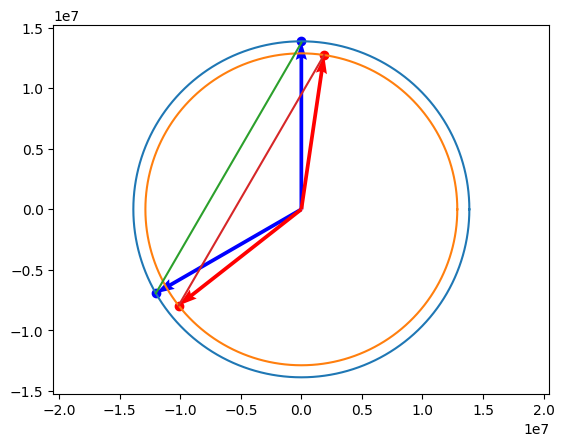

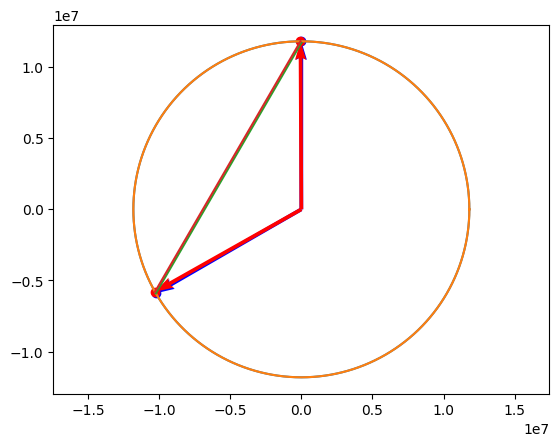

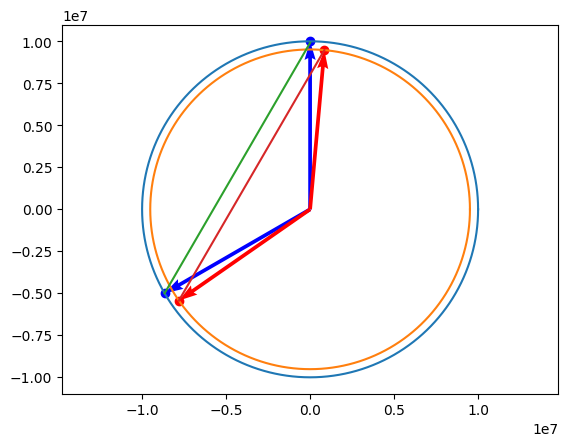

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import sympy as sym

# Parameters
cm, mm, um, nm = (1e-2, 1e-3, 1e-6, 1e-9)
wvl_record = np.array([488*nm, 532*nm, 660*nm])
wvl_disp_center = np.array([453*nm, 532*nm, 628*nm])
num_wvl = len(wvl_record)
shrinkage_HOE = 0.6 / 100 # achieved from project with naver labs
n_air = 1.000277
n_wg = 1.5 # later, this should be modified with consider of color aberration and HOE refractive index
theta_prism = np.deg2rad(60) # our thick 60-30-90-90 prism
phi_prism = float()
phi_mirror = float()
solution_BGR = dict()

# For HOE input coupler
for i in range(3):

   # Sign of angle is (+) when it is clockwise, (-) when it is CCW
   
   # Ideal angles for display's central wavelength inside the waveguide or HOE (n=1.5)
   alpha_air = np.deg2rad(0)
   #alpha_air = -angle_PG_deflect(wvl_disp_center[i]) # diflected angle in air by the PG (reference alpha)
   alpha_wg = np.arcsin(n_air/n_wg * np.sin(alpha_air)) # refracted light angle in wvg
   beta_wg = theta_prism # TIR angle in waveguide
   
   k_ref = 2*np.pi / wvl_record[i]
   k_disp = 2*np.pi / wvl_disp_center[i]

   # For plotting
   x_domain = np.linspace(-k_disp, k_disp, 1001)
   y_domain = np.linspace(-k_disp, k_disp, 1001)
   angle_domain = np.deg2rad(np.linspace(0, 360, 721))
   xx, yy = np.meshgrid(x_domain, y_domain)

   # Draw k-vector circles
   plt.figure()
   plt.plot(k_disp*np.cos(angle_domain), k_disp*np.sin(angle_domain))
   plt.plot(k_ref*np.cos(angle_domain), k_ref*np.sin(angle_domain))

   k_vec_d_in_ref = k_disp * np.array([np.sin(alpha_wg), np.cos(alpha_wg)], dtype='float')
   k_vec_d_in_sig = k_disp * np.array([-np.sin(beta_wg), -np.cos(beta_wg)], dtype='float')
   K_vec_d_in = k_vec_d_in_ref - k_vec_d_in_sig


   # grating vector which should be generated
   K_vec_d_in_precomp = K_vec_d_in
   K_vec_d_in_precomp[1] = 1/(1+shrinkage_HOE) * K_vec_d_in[1]
   print(K_vec_d_in)
   print(K_vec_d_in_precomp)

   plt.quiver(0, 0, k_vec_d_in_ref[0], k_vec_d_in_ref[1], units='xy', scale=1, color='b')
   plt.quiver(0, 0, k_vec_d_in_sig[0], k_vec_d_in_sig[1], units='xy', scale=1, color='b')
   plt.plot([k_vec_d_in_sig[0], k_vec_d_in_sig[0] + K_vec_d_in[0]],[k_vec_d_in_sig[1], k_vec_d_in_sig[1] + K_vec_d_in[1]])
   plt.scatter(k_vec_d_in_ref[0], k_vec_d_in_ref[1], color='b')
   plt.scatter(k_vec_d_in_sig[0], k_vec_d_in_sig[1], color='b')

   x = sym.symbols('x')
   z = sym.symbols('z')
   eq1 = x**2 + z**2 - k_ref **2
   eq2 = (x+K_vec_d_in_precomp[0])**2 + (z+K_vec_d_in_precomp[1])**2 - k_ref**2

   solutions = sym.solve([eq1, eq2], real=True)
   solution_BGR[i] = solutions[0]

   k_vec_r_in_ref = np.array([solution_BGR[i][x]+K_vec_d_in_precomp[0], solution_BGR[i][z]+K_vec_d_in_precomp[1]], dtype=float)
   k_vec_r_in_sig = np.array([solution_BGR[i][x], solution_BGR[i][z]], dtype=float)
   K_vec_by_record = k_vec_r_in_ref - k_vec_r_in_sig
   K_vec_by_record[1] = (1+shrinkage_HOE)*K_vec_by_record[1]

   print(K_vec_d_in)
   print(K_vec_by_record)

   plt.quiver(0, 0, k_vec_r_in_ref[0], k_vec_r_in_ref[1], units='xy', scale=1, color='r')
   plt.quiver(0, 0, k_vec_r_in_sig[0], k_vec_r_in_sig[1], units='xy', scale=1, color='r')
   plt.plot([k_vec_r_in_sig[0], k_vec_r_in_sig[0] + K_vec_d_in_precomp[0]],[k_vec_r_in_sig[1], k_vec_r_in_sig[1] + K_vec_d_in_precomp[1]])
   plt.scatter(k_vec_r_in_ref[0], k_vec_r_in_ref[1], color='r')
   plt.scatter(k_vec_r_in_sig[0], k_vec_r_in_sig[1], color='r')


   NEW_beta_wg = np.arctan(k_vec_r_in_sig[0]/k_vec_r_in_sig[1])
   print('NEW_beta_wg=',np.rad2deg(NEW_beta_wg))
   phi_prism_wg = theta_prism - NEW_beta_wg
   phi_prism_air = np.arcsin(n_wg / n_air * phi_prism_wg)

   NEW_alpha_wg = np.arctan(k_vec_r_in_ref[0]/k_vec_r_in_ref[1])
   phi_mirror_air = np.arcsin(n_wg/n_air*np.sin(NEW_alpha_wg)) + phi_prism_air

   print('phi_prism_air=',np.rad2deg(phi_prism_air))
   print('phi_mirror_air=',np.rad2deg(phi_mirror_air))

   plt.axis('equal')




def angle_PG_deflect(input_lambda):
   lambda_grating = 3.2*um
   lambda_light = input_lambda
   k = 2*np.pi / lambda_light
   K = 2*np.pi / lambda_grating
   deflect_angle = np.arctan(K/np.sqrt(k**2-K**2))
   return deflect_angle # unit --> radians

def angle_after_refract(theta, n_first, n_second):
   refract_angle = np.arcsin(n_first/n_second * np.sin(theta))
   return refract_angle # unit --> radians


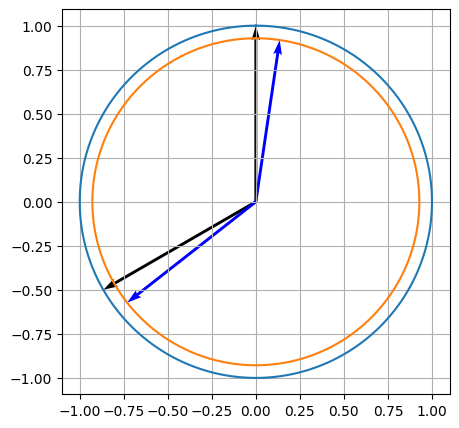

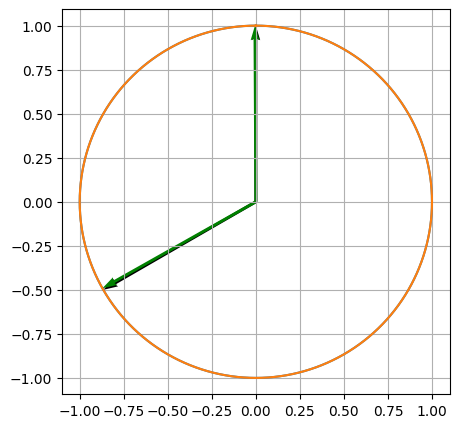

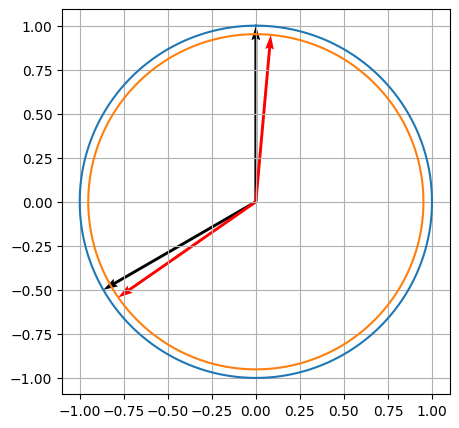

In [107]:
import numpy as np
import matplotlib.pyplot as plt


# Parameters
cm, mm, um, nm = (1e-2, 1e-3, 1e-6, 1e-9)
wvl_record = np.array([488*nm, 532*nm, 660*nm])
wvl_disp_center = np.array([453*nm, 532*nm, 628*nm])
num_wvl = len(wvl_record)
shrinkage_HOE = 0.6 / 100 # achieved from project with naver labs
n_air = 1.000277
n_wg = 1.5 # later, this should be modified with consider of color aberration and HOE refractive index
theta_prism = np.deg2rad(60) # our thick 60-30-90-90 prism
phi_prism = float()
phi_mirror = float()
solution_BGR = dict()


for i in range(num_wvl):
   # wavenumber of recording and display light
   k_r = 2*np.pi / wvl_record[i] 
   k_d = 2*np.pi / wvl_disp_center[i] # this is the reference wavelength which makes normalized k-vector
   k_ratio = k_r/k_d

   # Ideal angles for display's central wavelength inside the waveguide or HOE (n=1.5)
   # Sign of angle is (-) when it is clockwise, (+) when it is CCW
   alpha_out_ideal = np.array(np.pi/2)
   beta_out_ideal = np.array(1) * (-np.pi/2-theta_prism)   
   alpha_in_ideal = np.array(1) * (np.pi/2 + angle_PG_deflect(wvl_disp_center[i]))
   beta_in_ideal = beta_out_ideal

   # Ideal unit k-vectors and grating vector K
   k_uvec_out_ref = np.array([np.cos(alpha_out_ideal), np.sin(alpha_out_ideal)])
   k_uvec_out_sig = np.array([np.cos(beta_out_ideal), np.sin(beta_out_ideal)])
   k_uvec_in_ref = np.array([np.cos(alpha_in_ideal), np.sin(alpha_in_ideal)])
   k_uvec_in_sig = np.array([np.cos(beta_in_ideal), np.sin(beta_in_ideal)])
   
   # These grating vector should be recorded to the HOE.
   K_uvec_out_ideal = k_uvec_out_ref - k_uvec_out_sig
   K_uvec_in_ideal = k_uvec_in_ref - k_uvec_in_sig

   # However, there is a shrinkage at the HOE fixing process
   # These are pro-compensated K-vector for recording
   K_uvec_out_precomp = np.array([K_uvec_out_ideal[0], 1/(1+shrinkage_HOE)*K_uvec_out_ideal[1]])
   K_uvec_in_precomp = np.array([K_uvec_in_ideal[0], 1/(1+shrinkage_HOE)*K_uvec_in_ideal[1]])
   
   # Let's find two coordinates where precompensated K-vector fits in k-circle of recording wavelength
   # Used calculated equations
   a = K_uvec_out_precomp[0]; b = K_uvec_out_precomp[1]
   x1_out = -(a**2 - 2*b*(b/2 + (a*(-(a**2 + b**2 - 4*k_ratio**2)/(a**2 + b**2))**(1/2))/2) + b**2)/(2*a)
   x2_out = -(a**2 - 2*b*(b/2 - (a*(-(a**2 + b**2 - 4*k_ratio**2)/(a**2 + b**2))**(1/2))/2) + b**2)/(2*a)
   z1_out = - b/2 - (a*(-(a**2 + b**2 - 4*k_ratio**2)/(a**2 + b**2))**(1/2))/2
   z2_out = - b/2 + (a*(-(a**2 + b**2 - 4*k_ratio**2)/(a**2 + b**2))**(1/2))/2
   flag1 = abs(k_uvec_out_sig[0]-x1_out)
   flag2 = abs(k_uvec_out_sig[0]-x2_out)
   if flag1 > flag2:
      k_uvec_out_sig_record = np.array([x2_out, z2_out])
   else:
      k_uvec_out_sig_record = np.array([x1_out, z1_out])
   k_uvec_out_ref_record = k_uvec_out_sig_record + K_uvec_out_precomp

   a = K_uvec_in_precomp[0]; b = K_uvec_in_precomp[1]
   x1_in = -(a**2 - 2*b*(b/2 + (a*(-(a**2 + b**2 - 4*k_ratio**2)/(a**2 + b**2))**(1/2))/2) + b**2)/(2*a)
   x2_in = -(a**2 - 2*b*(b/2 - (a*(-(a**2 + b**2 - 4*k_ratio**2)/(a**2 + b**2))**(1/2))/2) + b**2)/(2*a)
   z1_in = - b/2 - (a*(-(a**2 + b**2 - 4*k_ratio**2)/(a**2 + b**2))**(1/2))/2
   z2_in = - b/2 + (a*(-(a**2 + b**2 - 4*k_ratio**2)/(a**2 + b**2))**(1/2))/2
   flag1 = abs(k_uvec_in_sig[0]-x1_in)
   flag2 = abs(k_uvec_in_sig[0]-x2_in)
   if flag1 > flag2:
      k_uvec_in_sig_record = np.array([x2_in, z2_in])
   else:
      k_uvec_in_sig_record = np.array([x1_in, z1_in])
   k_uvec_in_ref_record = k_uvec_in_sig_record + K_uvec_in_precomp
   k_uvec_in_ref_record = k_uvec_in_sig_record + K_uvec_in_precomp



   

   # For plotting
   x_domain = np.linspace(-1, 1, 1001)
   y_domain = np.linspace(-1, 1, 1001)
   color_ = ['b', 'g', 'r']
   theta_domain = np.deg2rad(np.linspace(0, 360, 721))
   plt.figure(figsize=(5,5))
   plt.grid()
   plt.plot(np.sin(theta_domain), np.cos(theta_domain))
   plt.plot(k_ratio * np.sin(theta_domain), k_ratio * np.cos(theta_domain))
   plt.quiver(0, 0, k_uvec_out_ref[0], k_uvec_out_ref[1], units='xy', scale=1, color='k')
   plt.quiver(0, 0, k_uvec_out_sig[0], k_uvec_out_sig[1], units='xy', scale=1, color='k')
   plt.quiver(0, 0, k_uvec_out_ref_record[0], k_uvec_out_ref_record[1], units='xy', scale=1, color=color_[i])
   plt.quiver(0, 0, k_uvec_out_sig_record[0], k_uvec_out_sig_record[1], units='xy', scale=1, color=color_[i])
   plt.axis('equal')

   plt.show()


   




def angle_PG_deflect(input_wvl, Period_grating=3.2*um):
   # Default PG has 10 degrees deflection at 550nm
   k = 2*np.pi / input_wvl
   K = 2*np.pi / Period_grating
   deflect_angle = np.arctan(K/np.sqrt(k**2-K**2))
   return deflect_angle # unit --> radians

def angle_after_refract(theta, n_first, n_second):
   refract_angle = np.arcsin(n_first/n_second * np.sin(theta))
   return refract_angle # unit --> radians

In [36]:
import plotly.express as px
import plotly.graph_objects as go
import plotly
import numpy as np
import pandas as pd

x = np.linspace(0, 100, 1001)
y = np.cos(x)
print(y)

fig = px.line(y)
fig.show()

[1.         0.99500417 0.98006658 ... 0.74453058 0.80745866 0.86231887]
